## Lab 01. Poetry generation

Let's try to generate some poetry using RNNs. 

You have several choices here: 

* The Shakespeare sonnets, file `sonnets.txt` available in the notebook directory.

* Роман в стихах "Евгений Онегин" Александра Сергеевича Пушкина. В предобработанном виде доступен по [ссылке](https://github.com/attatrol/data_sources/blob/master/onegin.txt).

* Some other text source, if it will be approved by the course staff.

Text generation can be designed in several steps:
    
1. Data loading.
2. Dictionary generation.
3. Data preprocessing.
4. Model (neural network) training.
5. Text generation (model evaluation).


In [1]:
import string
import os

### Data loading: Shakespeare

Shakespeare sonnets are awailable at this [link](http://www.gutenberg.org/ebooks/1041?msg=welcome_stranger). In addition, they are stored in the same directory as this notebook (`sonnetes.txt`). Simple preprocessing is already done for you in the next cell: all technical info is dropped.

In [2]:
if not os.path.exists('sonnets.txt'):
    !wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/master/homeworks_basic/Lab2_DL/sonnets.txt

with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [3]:
# Join all the strings into one and lowercase it
# Put result into variable text.

text = ''.join(text).lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


Put all the characters, that you've seen in the text, into variable `tokens`.

In [4]:
tokens = sorted(set(text))

Create dictionary `token_to_idx = {<char>: <index>}` and dictionary `idx_to_token = {<index>: <char>}`

In [5]:
# dict <index>:<char>
token_to_idx = {c: idx for idx, c in enumerate(tokens)}

# dict <char>:<index>
idx_to_token  = {idx: c for idx, c in enumerate(tokens)}

num_tokens = len(tokens)

num_tokens, len(token_to_idx), len(idx_to_token)

(38, 38, 38)

*Comment: in this task we have only 38 different tokens, so let's use one-hot encoding.*

### Building the model

Now we want to build and train recurrent neural net which would be able to something similar to Shakespeare's poetry.

Let's use vanilla RNN, similar to the one created during the lesson.

In [6]:
%reload_ext autoreload
%autoreload 1
%aimport utils

from utils import *

import torch
import re
import matplotlib.pyplot as plt
%matplotlib inline

# device = torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [7]:
def parse_shakespeare(texts):
    """Parses sonnet lines"""
    sonnets = []
    sonnet_lines = []
    for line in texts.split('\n'):
        if len(line.strip()) < 7: # ignore short lines
            if len(sonnet_lines):
                sonnets.append(''.join(sonnet_lines))
                sonnet_lines = []
        else:
            line = line.lower().replace('  ', ' ').replace('  ', ' ') # remove duplicate spaces
            sonnet_lines.append(line + '\n')
    if sonnet_lines: # Last sonnet
        sonnets.append(''.join(sonnet_lines))
        
    return sonnets
parse_shakespeare(text)[:3]

[" from fairest creatures we desire increase,\n that thereby beauty's rose might never die,\n but as the riper should by time decease,\n his tender heir might bear his memory:\n but thou, contracted to thine own bright eyes,\n feed'st thy light's flame with self-substantial fuel,\n making a famine where abundance lies,\n thy self thy foe, to thy sweet self too cruel:\n thou that art now the world's fresh ornament,\n and only herald to the gaudy spring,\n within thine own bud buriest thy content,\n and tender churl mak'st waste in niggarding:\n pity the world, or else this glutton be,\n to eat the world's due, by the grave and thee.\n",
 " when forty winters shall besiege thy brow,\n and dig deep trenches in thy beauty's field,\n thy youth's proud livery so gazed on now,\n will be a tatter'd weed of small worth held:\n then being asked, where all thy beauty lies,\n where all the treasure of thy lusty days;\n to say, within thine own deep sunken eyes,\n were an all-eating shame, and thri

In [8]:
MAX_SONNET_LENGTH = max([len(sonnet) for sonnet in parse_shakespeare(text)])
print(f'Max length of sonnet is {MAX_SONNET_LENGTH} symbols')

Max length of sonnet is 691 symbols


In [9]:
class CharRNN(nn.Module):
    def __init__(self, num_tokens=32, emb_size=16, rnn_num_units=32):
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(num_tokens + 1, emb_size, padding_idx=num_tokens)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h_seq, hidden = self.rnn(self.emb(x), hidden)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hidden
        else:
            h_seq, _ = self.rnn(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits

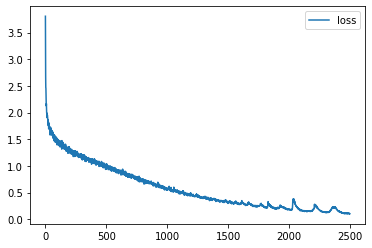

Loss = 0.10539869


In [10]:
lr = 1e-3
char_rnn = CharRNN(num_tokens=num_tokens, emb_size=MAX_SONNET_LENGTH, rnn_num_units=384).to(device)
trainable_params = [param for param in char_rnn.parameters() if param.requires_grad]
opt = torch.optim.Adam(trainable_params, lr=lr)
lr_scheduler = None

criterion = nn.CrossEntropyLoss(ignore_index=num_tokens + 1)

rnn_generate = TextGenerate(token_to_idx, idx_to_token, device)
loss_rnn = rnn_generate.train_model(char_rnn, opt, lr_scheduler, criterion, parse_shakespeare(text), n_iter=2_500)
print('Loss =', loss_rnn)

In [11]:
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    text_out = re.sub('[\n]+', '\n', rnn_generate.generate_sample(char_rnn, ' ', 200, temperature))
    print(f"temperature {temperature}:\n", text_out + ('' if text_out[-1] == '\n' else '\n'))
print()

temperature 0.1:
  then hate on, for now i have noted, and lascivious comments on thy special and bright of prais'd,
 as physing me, the earth can no pine others, being your vireful you take away,
 death's second seaut

temperature 0.2:
  then hate me when thou wilt; if ever, now;
 now, while the world is bent my deeds to cross,
 beauty with warragge is pleasure be it not say
 to ling, and tenors should i am not, if thou wouldst conve

temperature 0.5:
  let me not to the hasted, and like no more heaven itself for love, though muse, and oldremoting still,
 to show lends to them against thy sight?
 or what gift, that my adder's summer shall not false 

temperature 1.0:
  when i have seen darms olvence,
 without thy might to me,
 riche and out to make me love have is plain
 from their knowly thee.
 but do not love's said bitter imoffess it given the star!
 against thi

temperature 2.0:
  what, you bearing titne, it revenunt infet
 when fire for i most fig
 aht war now call im childrening

### More poetic model

Let's use LSTM instead of vanilla RNN and compare the results.

Plot the loss function of the number of epochs. Does the final loss become better?

In [12]:
class CharLSTM(nn.Module):
    def __init__(self, num_tokens=32, emb_size=64, num_units=64, num_layers=2, dropout=0.):
        super(self.__class__, self).__init__()
        
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.lstm = nn.LSTM(emb_size, num_units, batch_first=True, num_layers=num_layers, dropout=dropout)
        self.hid_to_logits = nn.Linear(num_units, num_tokens)
        
    def forward(self, x, hidden=None):
        if hidden is not None:
            h_seq, hidden = self.lstm(self.emb(x), hidden)
            next_logits = self.hid_to_logits(h_seq)
            return next_logits, hidden
        else:
            h_seq, _ = self.lstm(self.emb(x))
            next_logits = self.hid_to_logits(h_seq)
            return next_logits

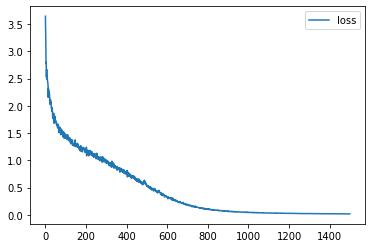

Loss = 0.10539869


In [13]:
lr = 1e-3
char_lstm = CharLSTM(num_tokens=num_tokens, emb_size=MAX_SONNET_LENGTH, num_units=384, dropout=0.05).to(device)
trainable_params = [param for param in char_lstm.parameters() if param.requires_grad]
opt = torch.optim.Adam(trainable_params, lr=lr)
lr_scheduler = None

criterion = nn.CrossEntropyLoss(ignore_index=num_tokens + 1)

lstm_generate = TextGenerate(token_to_idx, idx_to_token, device)
loss_lstm = lstm_generate.train_model(char_lstm, opt, lr_scheduler, criterion, parse_shakespeare(text), n_iter=1_500)
print('Loss =', loss_rnn)

Generate text using the trained net with different `temperature` parameter: `[0.1, 0.2, 0.5, 1.0, 2.0]`.

Evaluate the results visually, try to interpret them.

In [14]:
# Text generation with different temperature values here
for temperature in [0.1, 0.2, 0.5, 1.0, 2.0]:
    text_out = re.sub('[\n]+', '\n', lstm_generate.generate_sample(char_rnn, ' ', 500, temperature))
    print(f"temperature {temperature}:\n", text_out + ('' if text_out[-1] == '\n' else '\n'))
print()

temperature 0.1:
  then let not winter's ragged hand deface,
 in thee thy summer's sall.

temperature 0.2:
  when to the sessions of sweet silent thought
 i summon up remembrance of things past,
 i sigh the lack of many a thing i sought,
 and with old woes not bore bravely gay,
 with you,
 my life hath shows, and steal thy sweet his spite to this shamef receives rain still,
 and i peisune others, thought but destifly live in this,
 upon that which thy praises heart with weary travell o'ersways him with full grown'd?
 o! thou art from my love's sweet face shower with baway,
 to thy fair of such morem d

temperature 0.5:
  thy glass will shine by their brow,
 i see thee to thine eyes but leave me with single world ourseans the steel siggar perfection but a life remain,
 but besides way, my name be true despite thy sweet self to be i'll fulfil thy hunding tomb.
 then we purge;
 to the love wastes of time me thy love, thou my love receivest,
 i cannot blame thee, for my love thou usest, wi

### Saving and loading models

Save the model to the disk, then load it and generate text. Examples are available [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html]).

In [15]:
# Saving and loading code here
model_path = 'char_lstm.pth'
torch.save(char_lstm.state_dict(), model_path)

model = CharLSTM(num_tokens=num_tokens, emb_size=MAX_SONNET_LENGTH, num_units=384, dropout=0.1)
model.load_state_dict(torch.load(model_path))
model.to(device)

print(re.sub('[\n]+', '\n', lstm_generate.generate_sample(model, ' from', 160, 1.)))

 from fairest creatures we desire increase,
 that thereby beauty's rose might never die,
 but as the riper should by time decease,
 his tender his with moretned


### Data loading: "Евгений Онегин"

In [16]:
if not os.path.exists('onegin.txt'):
    !wget https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt

with open('onegin.txt', 'r') as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

--2021-04-22 06:52:46--  https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 262521 (256K) [text/plain]
Saving to: ‘onegin.txt’

onegin.txt          100%[===================>] 256.37K  --.-KB/s    in 0.02s   

2021-04-22 06:52:46 (13.1 MB/s) - ‘onegin.txt’ saved [262521/262521]



In opposite to the in-class practice, this time we want to predict complex text. Let's reduce the complexity of the task and lowercase all the symbols.

Now variable `text` is a list of strings. Join all the strings into one and lowercase it.

In [17]:
text = ''.join(text).lower()

tokens = sorted(set(text))
token_to_idx = {c: idx for idx, c in enumerate(tokens)}
idx_to_token  = {idx: c for idx, c in enumerate(tokens)}
num_tokens = len(tokens)

num_tokens, len(token_to_idx), len(idx_to_token)

(83, 83, 83)

In [18]:
text.split('\n')[:6]

['',
 'i',
 '',
 '«мой дядя самых честных правил,',
 'когда не в шутку занемог,',
 'он уважать себя заставил']

In [19]:
def parse_onegin(texts):
    """Parses Onegin lines"""
    sonnets = []
    sonnet_lines = []
    for line in texts.split('\n'):
        if len(line.strip()) < 7: # ignore short lines
            if len(sonnet_lines):
                sonnets.append(''.join(sonnet_lines))
                sonnet_lines = []
        else:
            line = line.lower().replace('  ', ' ').replace('  ', ' ') # remove duplicate spaces
            sonnet_lines.append(line + '\n')
    if sonnet_lines: # Last sonnet
        sonnets.append(''.join(sonnet_lines))
        
    return sonnets
parse_onegin(text)[:3]

['«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\n',
 'так думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меня\n',
 'служив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но мил.\nmonsieur l’ab

In [20]:
MAX_TEXT_LENGTH = max([len(sonnet) for sonnet in parse_onegin(text)])
print(f'Max length of text is {MAX_TEXT_LENGTH} symbols')

Max length of text is 1509 symbols


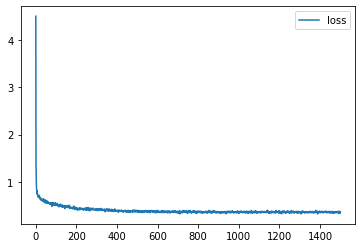

Loss = 0.33529666


In [21]:
lr = 1e-2
char_lstm = CharLSTM(num_tokens=num_tokens, emb_size=MAX_TEXT_LENGTH, num_units=384, dropout=0.05).to(device)
trainable_params = [param for param in char_lstm.parameters() if param.requires_grad]
opt = torch.optim.Adam(trainable_params, lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, 200, gamma=0.3)

criterion = nn.CrossEntropyLoss(ignore_index=num_tokens + 1)

lstm_generate = TextGenerate(token_to_idx, idx_to_token, device)
loss_lstm = lstm_generate.train_model(char_lstm, opt, lr_scheduler, criterion, parse_onegin(text), n_iter=1_500)
print('Loss =', loss_lstm)

In [22]:
print(lstm_generate.generate_sample(char_lstm, ' ', 400, 0.2).strip())

ней не приветает,
и в сердце приятно в самом дела,
привычка молодой страстью свет.


In [23]:
print(lstm_generate.generate_sample(char_lstm, ' ', 400, 0.3).strip())

внеминный простой
не мог не преданный сон.
то всё бедный снова за столом
своей слез и вольности подоброй
не славал он показалась лет.


In [24]:
print(lstm_generate.generate_sample(char_lstm, ' ', 400, 0.5).strip())

нет она всех нет;
достину всех науки,
и в сердце труда татьяна своей;
под ним не приветель умел;
кресто отворить не всех суне
и, хотя не приветель,
рассказал толка слова, никогда?
накак сердца поэты законец
к томный уголковать соседа
меня весель она в санях,
он от садите на была.
как в сердце при вы следаньем,
и славы не вступленьем дорог
и как матерь отом уж света
при в ней оставился без верной


In [25]:
print(lstm_generate.generate_sample(char_lstm, ' ', 400, 1.0).strip())

в собнызка брещной,
что но делствую бежало,
луна, сквозь горятке труда
мне непришла девницской молоды,
болных раздавых, значирм
и лета пора за находа
шужит ленский молюду
личиком одно. но я?),
– тамать им вновь ее ле пополной
полез книке льчатый сам,
туду, бежать люди: евгений,
хранит прелосить давничы:
всё вам ра сенима в мояр,
матьмари был и еесну, —
котер ее серде ей!..
друг счастьем послу; зн


### Факультативно
Возьмем в качестве обучающей выборки стихи Осипа Мандельштама

In [26]:
with open('mandelshtam.txt', 'r') as iofile:
    text = iofile.readlines()

text = ''.join(text).lower()

tokens = sorted(set(text))
token_to_idx = {c: idx for idx, c in enumerate(tokens)}
idx_to_token  = {idx: c for idx, c in enumerate(tokens)}
num_tokens = len(tokens)

num_tokens, len(token_to_idx), len(idx_to_token)

(73, 73, 73)

In [27]:
text.split('\n')[:6]

['звук осторожный и глухой',
 'плода, сорвавшегося с древа,',
 'среди немолчного напева',
 'глубокой тишины лесной…',
 '',
 '1908']

In [28]:
def parse_mandelshtam(texts):
    sonnets = []
    sonnet_lines = []
    for line in texts.split('\n'):
        if len(line.strip()) < 7:
            if len(sonnet_lines):
                if not (sonnet_lines[0].strip().startswith('*') or sonnet_lines[0].strip().startswith('_') or sonnet_lines[0].strip()[0].isnumeric()):
                    sonnets.append(''.join(sonnet_lines))
                sonnet_lines = []
        else:
            line = line.lower().replace('  ', ' ').replace('  ', ' ') # remove duplicate spaces
            sonnet_lines.append(' ' + line + '\n')
    if sonnet_lines: # Last sonnet
        sonnets.append(''.join(sonnet_lines))
        
    return sonnets

parse_mandelshtam(text)[:3]

[' звук осторожный и глухой\n плода, сорвавшегося с древа,\n среди немолчного напева\n глубокой тишины лесной…\n',
 ' мой тихий сон, мой сон ежеминутный –\n невидимый, завороженный лес,\n где носится какой-то шорох смутный,\n как дивный шелест шелковых завес.\n',
 ' в безумных встречах и туманных спорах,\n на перекрестке удивленных глаз\n невидимый и непонятный шорох\n под пеплом вспыхнул и уже погас.\n']

In [29]:
MAX_TEXT_LENGTH = max([len(sonnet) for sonnet in parse_mandelshtam(text)])
print(f'Max length of text is {MAX_TEXT_LENGTH} symbols')

Max length of text is 636 symbols


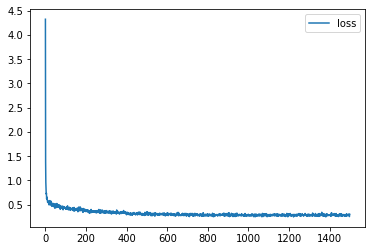

Loss = 0.30027905


In [30]:
lr = 1e-2
char_lstm = CharLSTM(num_tokens=num_tokens, emb_size=MAX_TEXT_LENGTH, num_units=384, dropout=0.05).to(device)
trainable_params = [param for param in char_lstm.parameters() if param.requires_grad]
opt = torch.optim.Adam(trainable_params, lr=lr)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, 200, gamma=0.3)

criterion = nn.CrossEntropyLoss(ignore_index=num_tokens + 1)

lstm_generate = TextGenerate(token_to_idx, idx_to_token, device)
loss_lstm = lstm_generate.train_model(char_lstm, opt, lr_scheduler, criterion, parse_mandelshtam(text), n_iter=1_500)
print('Loss =', loss_lstm)

In [31]:
print(lstm_generate.generate_sample(char_lstm, ' звук', 400, 0.2).strip())

звуков и не воздуха умерицы
 мне слово – соборой полной,
 и не воздуха в прозрачные воздуха –
 под колоколов и вода вольно,
 и словно в леса – в пространства полусот.


In [32]:
print(lstm_generate.generate_sample(char_lstm, ' звук', 400, 0.3).strip())

звуков безверенной ладина
 и не воздух густое полустала, и всемирный меря
 и страстный призрачных пританит –
 и в лесах и воздуха пошеленной страха
 в перед нам с улице темных страха
 и не страшно воздуха –
 не каменной бездная страница
 и не строительной тихом –
 и в полусоколавный и под строитель,
 и сознанье в небе нам собора.


In [33]:
print(lstm_generate.generate_sample(char_lstm, ' звук', 400, 0.5).strip())

звуков могучей ластотарцем морей…


In [34]:
print(lstm_generate.generate_sample(char_lstm, ' довольно', 400, 0.2).strip())

довольно собора – собора, ни века,
 как на стеной вечной странный и полусок,
 как полновый медленной раздыханье.


In [35]:
print(lstm_generate.generate_sample(char_lstm, ' довольно', 400, 0.3).strip())

довольно в небе облаков
 и вернулась в строительной дрожи
 и простиваю любить –
 небо летится, под соборы.


In [36]:
print(lstm_generate.generate_sample(char_lstm, ' довольно', 400, 0.5).strip())

довольно она рассказывала запечать:
 в сердце голубого в них – в колокола.


### References
1. <a href='http://karpathy.github.io/2015/05/21/rnn-effectiveness/'> Andrew Karpathy blog post about RNN. </a> 
There are several examples of genration: Shakespeare texts, Latex formulas, Linux Sourse Code and children names.
2. <a href='https://github.com/karpathy/char-rnn'> Repo with char-rnn code </a>
3. Cool repo with PyTorch examples: [link](https://github.com/spro/practical-pytorch`)